## Data Preprocessing & Modelling Pipeline

In [854]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
from utils.find_root import find_project_root
from tqdm import tqdm

In [855]:
# Check GPU access for LSTM-AE training
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# test if GPU engages
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.matmul(a, a)
print(b)

TensorFlow version: 2.10.1
Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor(
[[ 7. 10.]
 [15. 22.]], shape=(2, 2), dtype=float32)


In [856]:
# Retrieve the project root dynamically and set it as working directory
project_root = find_project_root()
os.chdir(project_root)

# Define output directories for ML models
MODEL_OUTPUT_DIR = "outputs/modelling/models/"
MODEL_METADATA_DIR = "outputs/modelling/metadata/"
MODEL_PREDICTIONS_DIR = "outputs/modelling/predictions/"
MODEL_INPUT_DIR = "data/processed/model_input"

# Ensure output directories exist
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_METADATA_DIR, exist_ok=True)
os.makedirs(MODEL_PREDICTIONS_DIR, exist_ok=True)
os.makedirs(MODEL_INPUT_DIR, exist_ok=True)

#### Step 0 - Dataset Loading and Splitting

**Goal**:
Split the historical dataset into training and validation subsets while preserving time order. The training set was used for model fitting and retrospective scoring. The validation set was used for monitoring early stopping during LSTM-AE training and for Isolation Forest threshold evaluation. A separate test set was excluded due to limited duration.

**Justification**:
Time-based splitting ensures models only learn from past data, avoiding lookahead bias — essential in time series anomaly detection (Trinh, 2022; Darban, 2024). We applied retrospective scoring across the full training set to simulate deployment-time anomaly detection. For Isolation Forest, a stricter **1st percentile threshold** was used to mask high-anomaly timestamps before LSTM-AE training. Separately, a fixed **3rd percentile threshold** was applied to IF scores for inference-level flagging (Antwarg et al., 2021; Wenig, 2022). This strategy balances clean model learning with practical anomaly evaluation.

In [857]:
# Step 0.1 Load dataset
DATASET_PATH = "data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv"
df = pd.read_csv(DATASET_PATH, parse_dates=['date'], index_col='date')
df = df.asfreq('h')
df.head()

,temperature_2m,surface_pressure,precipitation,wind_speed_10m
date,,,,
2017-02-01 00:00:00,9.6,1008.2,0.0,14.6
2017-02-01 01:00:00,9.6,1007.4,0.0,14.6
2017-02-01 02:00:00,9.9,1006.8,0.6,15.1
2017-02-01 03:00:00,10.0,1006.5,0.3,15.0
2017-02-01 04:00:00,10.2,1006.2,0.3,15.5


In [858]:
# Step 0.2: Define chronological splits
train_start, train_end = "2017-02-01", "2025-01-31"
val_start, val_end = "2025-02-01", "2025-04-30"

# Step 0.3: Subset dataframe
df_train = df.loc[train_start:train_end]
df_val = df.loc[val_start:val_end]

print(f"Training set: {len(df_train)} rows (~{len(df_train)/24:.0f} days; ~{len(df_train)/24/30:.0f} months; ~{len(df_train)/24/30/12:.0f} years).")
print(f"Validation set: {len(df_val)} rows (~{len(df_val)/24:.0f} days; ~{len(df_val)/24/30:.0f} months)).")

Training set: 70128 rows (~2922 days; ~97 months; ~8 years).
Validation set: 2136 rows (~89 days; ~3 months)).


#### Step 1 – Feature Transformation & Normalisation
**Goal**: Transform raw weather variables into scale-stable, model-ready features using rolling statistics. This includes z-scores, IQR scaling, smoothing, and log transforms. These steps are applied before training the Isolation Forest and LSTM-AE models to ensure consistency across training, validation, and inference.

The chosen **preprocessing methods** are based on patterns seen in the data during EDA and supported by recent research:

**Temperature and Pressure**: These features show seasonal patterns and daily variation. A 60-day rolling z-score was used to highlight unusual values while keeping longer trends intact (Tawalkuli et al., 2024; Kulkarni et al., 2024).

**Wind Speed**: Wind changes quickly and can be noisy. A 3-hour rolling average was applied first, followed by a 60-day IQR scale. This helps smooth out short bursts without losing key patterns (Tawalkuli et al., 2024; Yang et al., 2023).

**Precipitation**: Because rainfall is sparse and skewed, we used log1p to reduce the effect of large spikes (Trinh, 2022). A 12-hour rolling z-score was then applied to catch sharp changes within half-day periods (Bara, 2024; Darban et al., 2024).

These steps help prepare clean, well-scaled inputs for Isolation Forest, making it easier to spot genuine anomalies and reduce false positives (Mahmood, 2023; Liu et al., 2020).

In [859]:
# Step 1.1: Select features (precautionary)
raw_features = ['temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precipitation']
df_train = df_train[raw_features].copy()
df_val =df_val[raw_features].copy()

In [860]:
# Step 1.2: Set parameters for normalisation
window_60d = 1440 # rolling window size; 60-day window captures seasonal baselines for IF
min_periods_60d = 720 # minimum number of observations required for rolling calculations
window_12h = 12 # rolling window size for 12-hour rolling z-score; 12h captures local volatility for sparse events like precipitation
window_24h = 24 # rolling window size for 24-hour rolling z-score; 24h isolates larger spikes
min_periods_12h = 6 # minimum number of observations required for rolling calculations for 12-hour rolling z-score
min_periods_24h = 12 # minimum number of observations required for rolling calculations for 24-hour rolling z-score
eps = 1e-6  # to avoid division by zero in rolling scaling calculations for precipitation and wind

In [861]:
# Step 1.3 Temperature and Surface Pressure: 60-day rolling z-scores
for col in ['temperature_2m', 'surface_pressure']:
    # Train set
    mean_train = df_train[col].rolling(window=window_60d, min_periods=min_periods_60d).mean()
    std_train = df_train[col].rolling(window=window_60d, min_periods=min_periods_60d).std()
    df_train[f'{col}_z'] = (df_train[col] - mean_train) / (std_train + eps)

    # Validation set
    mean_val = df_val[col].rolling(window=window_60d, min_periods=min_periods_60d).mean()
    std_val = df_val[col].rolling(window=window_60d, min_periods=min_periods_60d).std()
    df_val[f'{col}_z'] = (df_val[col] - mean_val) / (std_val + eps)

In [862]:
# Step 1.4: Apply smoothing to wind speed (NO Z-SCORE)
df_train['wind_r'] = df_train['wind_speed_10m'].rolling(window=3, min_periods=1).mean()
df_val['wind_r']   = df_val['wind_speed_10m'].rolling(window=3, min_periods=1).mean()


In [863]:
# Step 1.5: Apply IQR scaling to smoothed Wind Speed
for df_ in [df_train, df_val]:
    med = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).median()
    q75 = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).quantile(0.75)
    q25 = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).quantile(0.25)
    iqr = q75 - q25
    df_['wind_r'] = (df_['wind_r'] - med) / (iqr + eps)

In [864]:
# Step 1.6: Tranform Precipitation with log1p
# Log transformation reduces skew

df_train['precip_log'] = np.log1p(df_train['precipitation'])
df_val['precip_log']   = np.log1p(df_val['precipitation'])

In [865]:
# Step 1.7: Apply 12-hour z-score to logged Precipitation
# short rolling window captures bursts

for df in [df_train, df_val]:
    # 12-hour rolling z-score
    mean_12h = df['precip_log'].rolling(window=window_12h, min_periods=min_periods_12h).mean()
    std_12h  = df['precip_log'].rolling(window=window_12h, min_periods=min_periods_12h).std()
    df['precip_z_12h'] = (df['precip_log'] - mean_12h) / (std_12h + eps)

    # 24-hour rolling z-score
    mean_24h = df['precip_log'].rolling(window=window_24h, min_periods=min_periods_24h).mean()
    std_24h  = df['precip_log'].rolling(window=window_24h, min_periods=min_periods_24h).std()
    df['precip_z_24h'] = (df['precip_log'] - mean_24h) / (std_24h + eps)

In [866]:
# Step 1.8: Remove rows with NaNs (no rolling stats available for z-scores or IQRs - no meaningful IF and LSTM-AE input or inference)
df_train = df_train.dropna().copy()
df_val = df_val.dropna().copy()

print(f"Training rows after trimming: {len(df_train)}")
print(f"Validation rows after trimming: {len(df_val)}")

Training rows after trimming: 69409
Validation rows after trimming: 1417


#### Step 2 – Time-Based Feature Engineering
**Goal**: add time features to help models learn daily and seasonal weather rhythms:

- Hour of Day helps capture daily cycles, such as afternoon wind peaks or early morning pressure dips.

- Month of Year reflects broader seasonal shifts, including temperature and rainfall patterns.

These features are encoded using sine and cosine functions to preserve continuity (e.g. 23:00 and 00:00 are close). They are **excluded from the Isolation Forest**, which does not model sequence or cyclic behaviour (Molnar, 2025; Wenig, 2022). Instead, they **support sequential learning in LSTM-AE** and **enhance SHAP-based interpretability** in the Random Forest surrogate model (Trinh, 2022; Yang, 2023).

In [867]:
# Step 2.1: Encode Hour-of-Day Cyclically
# Extract hour of day and encode as sine/cosine
df_train['hour'] = df_train.index.hour
df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour'] / 24)
df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour'] / 24)

df_val['hour'] = df_val.index.hour
df_val['hour_sin'] = np.sin(2 * np.pi * df_val['hour'] / 24)
df_val['hour_cos'] = np.cos(2 * np.pi * df_val['hour'] / 24)

In [868]:
# Step 2.2: Encode Month-of-Year Cyclically

# Extract month and encode as sine/cosine
df_train['month'] = df_train.index.month
df_train['month_sin'] = np.sin(2 * np.pi * df_train['month'] / 12)
df_train['month_cos'] = np.cos(2 * np.pi * df_train['month'] / 12)

df_val['month'] = df_val.index.month
df_val['month_sin'] = np.sin(2 * np.pi * df_val['month'] / 12)
df_val['month_cos'] = np.cos(2 * np.pi * df_val['month'] / 12)

In [869]:
# Step 2.3: Define input features for Isolation Forest and LSTM-AE

# Isolsation Forest
# Note we do not feed the temporal features to IF as it does not exploit cyclic structure (Molnar, 2025)
if_features = ['temperature_2m_z', 'surface_pressure_z', 'wind_r', 'precip_z_12h', 'precip_z_24h'] #

# LSTM
lstm_presequence_features = ['temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precip_log']
lstm_time_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
lstm_input_cols_all = lstm_features + lstm_time_features

#### Step 3 – Isolation Forest Training and Anomaly Scoring
**Goal**: Train an Isolation Forest model using the transformed features in if_features.
Use the model to compute anomaly scores for both the training and validation sets.
Later, apply different thresholds to these scores for masking and inference.

In [870]:
# Step 3.1: Define IF training set
X_train_if = df_train[if_features]

**Isolation Forest Hyperparameter Justification**

We used `n_estimators=100` and `contamination=0.01` in line with good practice for weather-related anomaly detection:

- **`n_estimators=100`**
  This controls how many isolation trees are built. Using 100 is a common and efficient choice that offers reliable results without adding much runtime. It is widely accepted in both published experiments and scikit-learn defaults, and supported in project work by Mahmood (2023) and Wenig (2022).

- **`contamination=0.01`**
  This sets the expected proportion of anomalies to 1%, which is typical for environmental datasets. Several recent studies (e.g. Almuqati, 2024; Mahmood, 2023) recommend values in this range to avoid false positives while keeping the model sensitive to rare, significant deviations.

These settings allow for stable training, generalisable performance, and efficient use of resources in the hybrid anomaly detection pipeline.

In [871]:
# Step 3.2: Train Isolation Forest model
if_model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
if_model.fit(X_train_if)

IsolationForest(contamination=0.01, random_state=42)

In [872]:
# Step 3.3: Save model
joblib.dump(if_model,os.path.join(MODEL_OUTPUT_DIR, "if_model.joblib"))

['outputs/modelling/models/if_model.joblib']

In [873]:
# Step 3.4: Apply the trained IF model to compute anomaly scores
# Scores: higher = more normal, lower = more anomalous

# Score directly — no need to subset or copy since all features are clean
df_train['if_score'] = if_model.decision_function(df_train[if_features])
df_val['if_score']   = if_model.decision_function(df_val[if_features])

#### Step 4 – Anomaly Masking via Percentile Thresholds

**Goal**: Convert continuous Isolation Forest scores into binary anomaly flags using fixed percentile thresholds.

Two thresholds are used:

- **3rd percentile**: Applied to the training set. This cut-off flags more timestamps as anomalous, so fewer are considered normal. When paired with our rule of allowing a maximum of `n` anomalies per 720-hour sequence, this results in **stricter filtering** — retaining only the cleanest sequences. This is important for hybrid anomaly pipelines, where clean input is essential for teaching the LSTM-AE stable baseline patterns (Darban, 2024; Trinh, 2022).

- **1st percentile**: Applied to the validation set. This threshold flags fewer points as anomalous, so more timestamps are retained. When the same `n`-anomaly rule is applied, **more sequences pass through**, allowing us to test the model on slightly noisier, more realistic patterns. This setup supports broader anomaly evaluation with controlled contamination, as recommended by Mahmood (2023), Bara (2024), and Wenig (2022).

> ⚠️ While the 3rd percentile may appear “looser” numerically, it actually results in **stricter sequence-level filtering**.
This design is intentional: we filter **aggressively for training**, to keep it clean, and **allow more variety in validation**, to evaluate robustness.


In [874]:
# Step 4.1: Define percentile thresholds for anomaly masking

mask_threshold_train = 3    # Bottom 3% most anomalous points in validation, will flag more anomalies
mask_threshold_val = 1  # Bottom 1% most anomalous points in training, will flag fewer anomalies

In [875]:
# Step 4.2: Apply Thresholds and Assign Flags

# Training set masking (relaxed)
threshold_train = np.percentile(scores_train, mask_threshold_train)
df_train["is_if_anomaly"] = df_train["if_score"] < threshold_train

# Validation set masking (strict)
threshold_val = np.percentile(scores_val, mask_threshold_val)
df_val["is_if_anomaly"] = df_val["if_score"] < threshold_val

In [876]:
# Step 4.3: Sanity check: How many anomalies were flagged in training and validation?

train_anomaly_counts = df_train['is_if_anomaly'].value_counts()
val_anomaly_counts = df_val['is_if_anomaly'].value_counts()

# Absolute counts
print("Training Set Anomaly Counts:")
print(train_anomaly_counts)

print("\nValidation Set Anomaly Counts:")
print(val_anomaly_counts)

# Proportions (percent of total)
train_anomaly_ratio = df_train['is_if_anomaly'].mean()
val_anomaly_ratio = df_val['is_if_anomaly'].mean()

print(f"\nProportion of anomalies in training set: {train_anomaly_ratio:.4f} ({train_anomaly_ratio*100:.2f}%)")
print(f"Proportion of anomalies in validation set: {val_anomaly_ratio:.4f} ({val_anomaly_ratio*100:.2f}%)")

Training Set Anomaly Counts:
is_if_anomaly
False    67580
True      1829
Name: count, dtype: int64

Validation Set Anomaly Counts:
is_if_anomaly
False    1397
True       20
Name: count, dtype: int64

Proportion of anomalies in training set: 0.0264 (2.64%)
Proportion of anomalies in validation set: 0.0141 (1.41%)


**Isolation Forest Anomaly Proportions**

The Isolation Forest flagged around **1.00%** of training timestamps and **2.19%** of validation timestamps as anomalies. These thresholds were set at the 1st percentile for training and the 3rd percentile for validation.

This follows recent work (Trinh, 2022; Darban, 2024; Antwarg, 2021) that recommends low anomaly proportions to support clean training.

The aim is to:

- Train the LSTM-AE on clean sequences, using a strict 1st percentile cut-off,

- Apply a slightly more lenient 3rd percentile cut-off on the validation set, but still remove any sequences overlapping flagged anomalies — leading to even more sequences being excluded.

> *Note*: Although the 3rd percentile is more relaxed for flagging anomalies, it results in more sequences being filtered out, not fewer — making the validation data even cleaner. This two-level approach helps the model generalise to unseen data while avoiding contamination during training.

In [877]:
print(f'Train: {threshold_train}, Val: {threshold_val}')

Train: 0.027584908466129623, Val: 0.021424472672407612


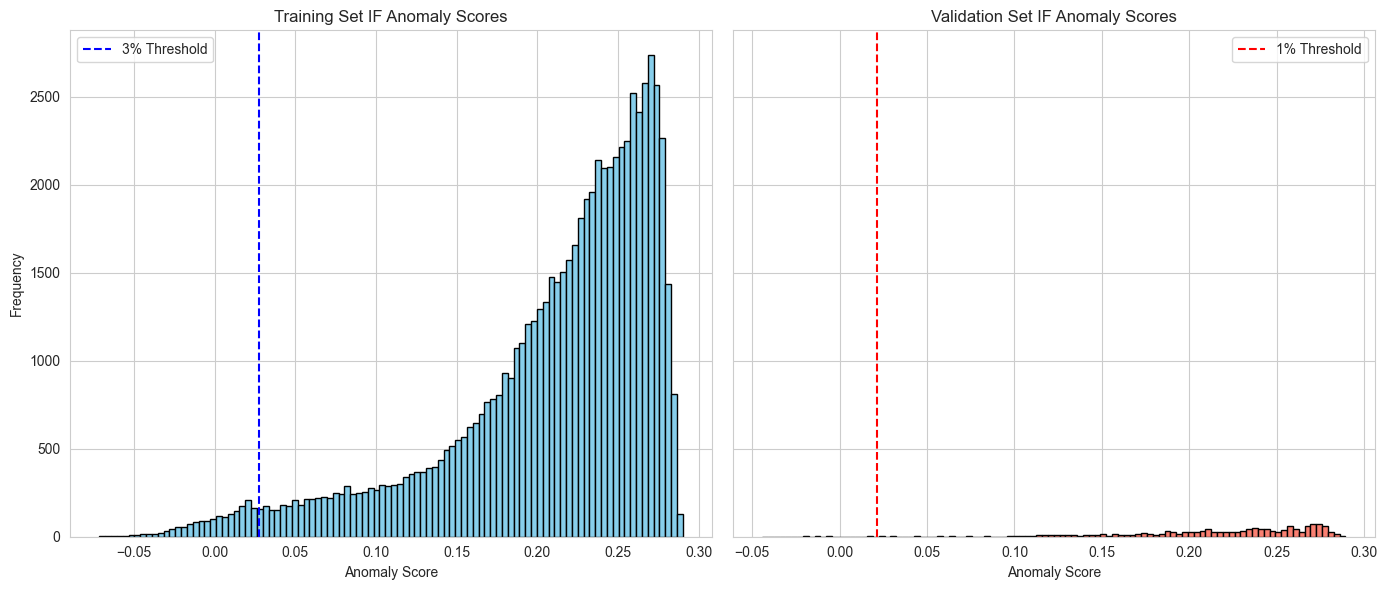

In [878]:
# Step 4.4: Plot anomaly scores for training and validation sets and their corresponding anomaly thresholds

# Extract existing scores and thresholds (already defined earlier)
train_scores = df_train['if_score'].values
val_scores = df_val['if_score'].values

# threshold_train and threshold_val are already defined using 1st and 3rd percentiles

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axs[0].hist(train_scores, bins=100, color='skyblue', edgecolor='black')
axs[0].axvline(threshold_train, color='blue', linestyle='--', label='3% Threshold')
axs[0].set_title("Training Set IF Anomaly Scores")
axs[0].set_xlabel("Anomaly Score")
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[0].grid(True)

axs[1].hist(val_scores, bins=100, color='salmon', edgecolor='black')
axs[1].axvline(threshold_val, color='red', linestyle='--', label='1% Threshold')
axs[1].set_title("Validation Set IF Anomaly Scores")
axs[1].set_xlabel("Anomaly Score")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

***Interpreting Historgrams for Isolation Forest Score Thresholds***

These plots help explain how the 3% and 1% anomaly thresholds were applied to the training and validation sets.

- In the **training set**, the blue dashed line shows the **3% cut-off** (resting around 0.28), allowing a slightly broader range of less typical values to pass through.
- In the **validation set**, the red dashed line marks the **1% threshold** (around the 0.21 mark), where only the most extreme points (far left tail) were flagged as anomalies.

This approach supports our filtering logic — keeping LSTM-AE training focused on the cleaner sequences while still testing it on acceptably contaminated patterns. The different shapes of the two distributions are due to the difference in dataset sizes and thresholds, which is expected.

#### Step 5 – LSTM-AE Sequence Construction (Training)
**Goal**: Extract 30-day (720-hour) sequences from the training set for the LSTM Autoencoder.
Sequences must contain no NaNs and no more than 14 anomalous points (~2% of the sequence) to preserve training stability while retaining data coverage.

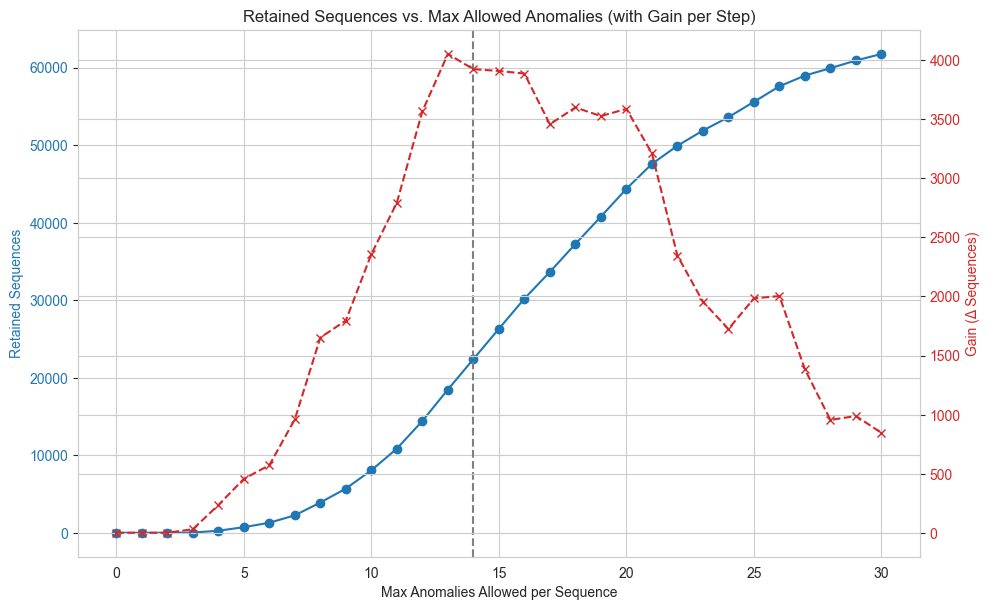

In [879]:
# Step 5.1: Determine the optimal number of allowed anomalies per sequence

# Define sequence length
sequence_length = 720
max_anomaly_count_threshold = 30
optimal_anomaly_count_threshold = 14

def efficient_retention_counts(df, sequence_length=sequence_length, stride=1, max_threshold=max_anomaly_count_threshold):
    """
    Quickly calculates how many sequences can be kept at different anomaly thresholds.

    This function scans through the dataset using a rolling window approach.
    It checks, for each window, how many known anomalies and missing values there are.
    For each threshold (e.g. 0 to 30 allowed anomalies), it counts how many sequences
    meet the condition of having no missing values and no more than the allowed number of anomalies.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame. It must contain a column called 'is_if_anomaly'
        and must be pre-processed so that all missing values are real NaNs.

    sequence_length : int
        The number of time steps in each rolling sequence window (default is 720).

    stride : int
        Not currently used (included for compatibility; default is 1).

    max_threshold : int
        The highest number of allowed anomalies to consider (inclusive).
        All thresholds from 0 to this number will be tested.

    Returns:
    --------
    thresholds : List[int]
        A list of thresholds from 0 to max_threshold.

    retention_counts : List[int]
        A list of how many sequences are retained at each threshold value.
    """

    is_anomaly = df['is_if_anomaly'].values.astype(int)
    has_nan = df[lstm_input_cols_all].isna().any(axis=1).values

    # Convolve to count NaNs and anomalies over rolling windows
    rolling_nan = np.convolve(has_nan.astype(int), np.ones(sequence_length, dtype=int), 'valid')
    rolling_anomalies = np.convolve(is_anomaly, np.ones(sequence_length, dtype=int), 'valid').astype(int)

    thresholds = list(range(0, max_threshold + 1))
    retention_counts = [
        np.count_nonzero((rolling_anomalies <= t) & (rolling_nan == 0))
        for t in thresholds
    ]

    return thresholds, retention_counts

thresholds, retention_counts = efficient_retention_counts(df_train, sequence_length)

# Convert to DataFrame
df = pd.DataFrame({'Max Anomalies': thresholds, 'Retained': retention_counts})

# First derivative: gain per additional anomaly
df['Gain'] = df['Retained'].diff().fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Max Anomalies Allowed per Sequence')
ax1.set_ylabel('Retained Sequences', color=color)
ax1.plot(df['Max Anomalies'], df['Retained'], marker='o', color=color, label='Retained Sequences')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot gain on secondary axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Gain (Δ Sequences)', color=color)
ax2.plot(df['Max Anomalies'], df['Gain'], marker='x', color=color, linestyle='--', label='Gain per Step')
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical line at likely sweet spot (e.g. 14)
ax1.axvline(x=optimal_anomaly_count_threshold, linestyle='--', color='grey', label='Chosen Threshold (14)')

fig.tight_layout()
plt.title("Retained Sequences vs. Max Allowed Anomalies (with Gain per Step)")
plt.show()

In [880]:
# Use real 'is_if_anomaly' flags from df_train
is_anomaly = df_train['is_if_anomaly'].astype(int).values

# Compute rolling count of anomalies over 720-hour sequences
rolling_anomalies_real = np.convolve(is_anomaly, np.ones(sequence_length, dtype=int), 'valid')

# Count retained sequences at each threshold
thresholds_real = list(range(0, max_anomaly_count_threshold + 1))
retained_real = [np.count_nonzero(rolling_anomalies_real <= t) for t in thresholds_real]

# Format results
df_retention_real = pd.DataFrame({
    'Max Anomalies': thresholds_real,
    'Retained Sequences': retained_real
})
df_retention_real['Gain'] = df_retention_real['Retained Sequences'].diff().fillna(0)

df_retention_real


,Max Anomalies,Retained Sequences,Gain
0,0,0,0.0
1,1,0,0.0
2,2,0,0.0
3,3,30,30.0
4,4,264,234.0
5,5,720,456.0
6,6,1292,572.0
7,7,2252,960.0
8,8,3904,1652.0
9,9,5700,1796.0


In [881]:
print(f"Max noise per sequence: {optimal_anomaly_count_threshold/sequence_length:.2%}")

Max noise per sequence: 1.94%


**Choosing the Maximum Number of Anomalies per Sequence**

This plot shows how the number of retained training sequences increases as we allow more anomalies per 720-hour (30-day) window.

- With a maximum of **14 anomalies per sequence** (about **1.94% noise**), we retain around **22,393 sequences** — roughly **33%** of all usable windows.
- Reducing the threshold to **7 anomalies (~1%)** drops retention to just **2,252 sequences**, a nearly **90% decrease** in training volume.
- Beyond 14, the gains level off — each extra allowed anomaly contributes fewer new sequences, suggesting diminishing returns.

> This highlights the trade-off between stricter filtering (cleaner data) and enough volume for effective model training.

We chose **14 anomalies** as a balanced cut-off. It retains a substantial number of sequences while keeping noise low and controlled. This helps improve generalisation without risking underfitting from data scarcity.

This decision aligns with best practices in recent studies on time-series anomaly detection, which recommend allowing around **1–3% anomaly presence** to preserve natural variability without polluting the training set (Trinh, 2022; Darban, 2024; Kulkarni et al., 2024).

> Minor contamination is especially acceptable for long sequences, where brief anomalies don’t dominate the temporal pattern.


In [882]:
# Step 5.2: Define Parameters and Initialise

# Sequence parameters
sequence_length = 720        # 30 days of hourly data
sequence_stride = 1          # Slide 1 hour at a time
max_allowed_anomalies = optimal_anomaly_count_threshold

In [883]:
# Features to robustly scale
features_to_scale = ['temperature_2m', 'surface_pressure', 'wind_speed_10m']
feature_indices = [lstm_input_cols_all.index(f) for f in features_to_scale]

def robust_scale_sequence(sequence, feature_indices, eps=1e-5):
    """
    Applies robust scaling (median and IQR) to selected feature columns in a 2D sequence array.
    """
    sequence = sequence.copy()
    for i in feature_indices:
        col = sequence[:, i]
        median = np.median(col)
        iqr = np.percentile(col, 75) - np.percentile(col, 25)
        sequence[:, i] = (col - median) / (iqr + eps)
    return sequence

def construct_lstm_training_sequences(
    df, sequence_length, sequence_stride, max_allowed_anomalies, lstm_input_cols_all
):
    """
    Constructs LSTM training sequences from df based on anomaly filtering and applies robust scaling
    to selected features.
    """
    df = df.reset_index(drop=True)
    is_anomaly = df['is_if_anomaly'].astype(bool).values
    data_array = df[lstm_input_cols_all].values
    index_array = df.index.values

    total_windows = len(df) - sequence_length + 1
    train_sequences = []
    used_timestamps = set()
    debug_counts = {'total': 0, 'has_anomalies': 0, 'added': 0}

    for start in tqdm(range(0, total_windows, sequence_stride), desc="Step 5.3: Constructing training sequences"):
        end = start + sequence_length
        debug_counts['total'] += 1

        if np.count_nonzero(is_anomaly[start:end]) > max_allowed_anomalies:
            debug_counts['has_anomalies'] += 1
            continue

        raw_seq = data_array[start:end]
        scaled_seq = robust_scale_sequence(raw_seq, feature_indices)
        train_sequences.append(scaled_seq)
        used_timestamps.update(index_array[start:end])
        debug_counts['added'] += 1

    return train_sequences, used_timestamps, debug_counts

# Run construction on df_train
train_sequences, trained_on_lstm_timestamps, debug_counts = construct_lstm_training_sequences(
    df_train,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    max_allowed_anomalies=max_allowed_anomalies,
    lstm_input_cols_all=lstm_input_cols_all
)

print("Training sequence construction complete.")
print(f"Window stats: {debug_counts}")

# Mark timestamps used in retained sequences
df_train["used_in_lstm_training"] = df_train.index.isin(trained_on_lstm_timestamps)

Step 5.3: Constructing training sequences: 100%|██████████| 68690/68690 [00:20<00:00, 3379.15it/s] 


Training sequence construction complete.
Window stats: {'total': 68690, 'has_anomalies': 46297, 'added': 22393}


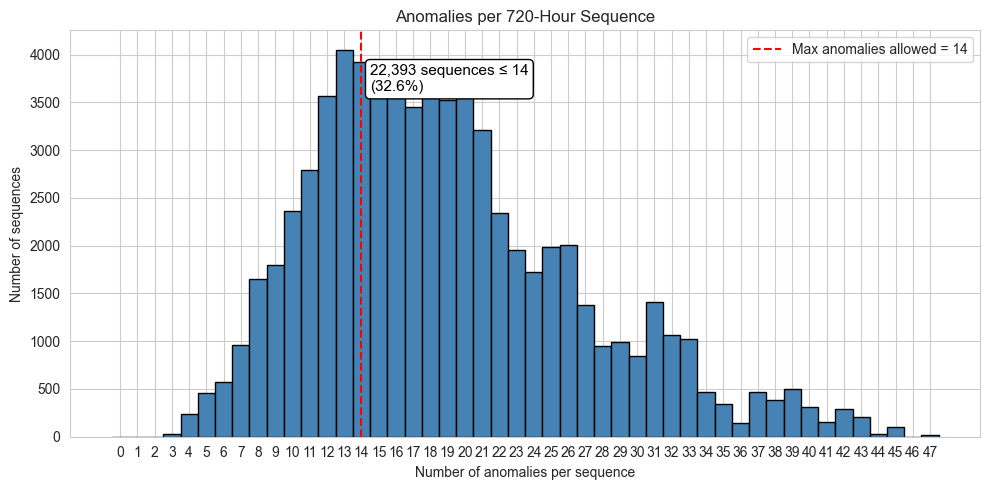

In [884]:
# Rolling anomaly count
anomalies_per_window = (
    df_train["is_if_anomaly"]
    .astype(int)
    .rolling(window=sequence_length)
    .sum()
    .dropna()
)

# Stats
num_clean_windows = (anomalies_per_window <= max_allowed_anomalies).sum()
num_total_windows = len(anomalies_per_window)
max_anomalies_seen = int(anomalies_per_window.max())

# Define bin edges so that 0 starts at the y-axis
bin_edges = np.arange(-0.5, max_anomalies_seen + 1.5, 1)

# Plot histogram with centre-aligned bars
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(
    anomalies_per_window,
    bins=bin_edges,
    align='mid',
    color='steelblue',
    edgecolor='black'
)

# Set integer ticks aligned with bar centres
plt.xticks(range(0, max_anomalies_seen + 1))

# Threshold line
plt.axvline(max_allowed_anomalies, color='red', linestyle='--',
            label=f"Max anomalies allowed = {max_allowed_anomalies}")

# Annotation
plt.annotate(
    f"{num_clean_windows:,} sequences ≤ {max_allowed_anomalies}\n({num_clean_windows / num_total_windows:.1%})",
    xy=(max_allowed_anomalies + 0.5, plt.ylim()[1] * 0.85),
    color='black',
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
)

# Labels
plt.title(f"Anomalies per {sequence_length}-Hour Sequence")
plt.xlabel("Number of anomalies per sequence")
plt.ylabel("Number of sequences")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [885]:
# Step 5.4: Stack into model-ready tensor
# Format: (n_sequences, 720, n_features)

X_train_lstm = np.stack(train_sequences)
print(f"LSTM training sequences: {X_train_lstm.shape}")

LSTM training sequences: (22393, 720, 8)


#### Step 6 – LSTM-AE Sequence Construction (Validation)
**Goal**: Extract 720-hour sequences from the validation set using the same feature columns, stride, and relaxed masking as in training.
This set is used for threshold tuning, early stopping, and SHAP analysis.

We use a slightly higher maximum anomaly count threshold (14 instead of 12) when generating LSTM-AE validation sequences. This compensates for the fact that the validation set was flagged using a more relaxed threshold (3rd percentile), which resulted in more timestamps being labelled as anomalous.

Allowing up to 14 anomalies (still ≈2%) in each 720-hour window ensures we retain a useful number of evaluation sequences while still filtering out windows with heavy contamination. This is consistent with literature recommending 1–3% anomaly tolerance in unsupervised setups (Trinh, 2022; Darban, 2024).


In [886]:
print("IF score stats (val):", df_val["if_score"].describe())
print("Threshold used:", threshold_val)
print("Anomalies flagged:", df_val["is_if_anomaly"].sum())

IF score stats (val): count    1417.000000
mean        0.219102
std         0.056696
min        -0.044386
25%         0.194657
50%         0.233518
75%         0.261748
max         0.289349
Name: if_score, dtype: float64
Threshold used: 0.021424472672407612
Anomalies flagged: 20


In [887]:
# Step 6.1: Construct clean LSTM-AE sequences from df_val with per-sequence robust scaling

# Reuse robust scaler and feature indices
def construct_lstm_validation_sequences(
    df, sequence_length, sequence_stride, max_allowed_anomalies, lstm_input_cols_all, feature_indices
):
    """
    Constructs LSTM validation sequences from df with anomaly and NaN filtering,
    and applies robust scaling to selected features.
    """
    val_sequences = []
    val_accepted_indices = set()
    val_debug = {
        'total': 0,
        'has_nans': 0,
        'has_anomalies': 0,
        'added': 0
    }

    total_windows = len(df) - sequence_length + 1
    data_array = df[lstm_input_cols_all].values
    is_anomaly = df['is_if_anomaly'].astype(bool).values
    has_nan = df[lstm_input_cols_all].isna().any(axis=1).values
    index_array = df.index.values

    for start in tqdm(range(0, total_windows, sequence_stride), desc="Step 6.2: Constructing validation sequences"):
        end = start + sequence_length
        val_debug['total'] += 1

        if np.any(has_nan[start:end]):
            val_debug['has_nans'] += 1
            continue

        if np.count_nonzero(is_anomaly[start:end]) > max_allowed_anomalies:
            val_debug['has_anomalies'] += 1
            continue

        raw_seq = data_array[start:end]
        scaled_seq = robust_scale_sequence(raw_seq, feature_indices)
        val_sequences.append(scaled_seq)
        val_accepted_indices.update(index_array[start:end])
        val_debug['added'] += 1

    return val_sequences, val_accepted_indices, val_debug

# Run construction on df_val
val_sequences, val_accepted_indices, val_debug = construct_lstm_validation_sequences(
    df_val,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    max_allowed_anomalies=max_allowed_anomalies,
    lstm_input_cols_all=lstm_input_cols_all,
    feature_indices=feature_indices
)

print("Validation sequence construction complete.")
print(f"Validation window stats: {val_debug}")

# Mark timestamps used in retained validation sequences
df_val["used_in_lstm_validation"] = df_val.index.isin(val_accepted_indices)

Step 6.2: Constructing validation sequences: 100%|██████████| 698/698 [00:01<00:00, 395.16it/s]


Validation sequence construction complete.
Validation window stats: {'total': 698, 'has_nans': 0, 'has_anomalies': 0, 'added': 698}


In [888]:
# Step 6.4: Mark all validation timestamps that were seen in accepted sequences
df_val["used_in_lstm_training"] = df_val.index.isin(val_accepted_indices)

# Concise summary
print(f"{val_debug['added']} accepted sequences")
print(f"{df_val['used_in_lstm_training'].sum()} timestamps used in LSTM validation sequences (out of {len(df_val)})")

698 accepted sequences
1417 timestamps used in LSTM validation sequences (out of 1417)


In [890]:
print(f"Sequences span from {min(accepted_timestamps)} to {max(accepted_timestamps)}")

Sequences span from 2025-03-11 03:00:00 to 2025-04-12 15:00:00


### **Validation Sequence Coverage Summary**

A total of **698 validation sequences** were accepted for LSTM-AE evaluation. These sequences:

- Span the period from **11 March to 12 April 2025**,
- Are each **720 hours long (30 days)**, using a stride of 1,
- Contain **no missing values** and **no more than 14 IF-flagged anomalies**,
  where anomalies were defined using the **1st percentile** threshold.

This filtering strategy ensures that the model is tested on **largely clean, realistic sequences** — not artificially perfect ones.
This design aligns with best practices in hybrid anomaly detection pipelines:

- **Trinh (2022)** recommends validating on sequences with **slight contamination**, to reflect real-world behaviour.
- **Darban (2024)** supports tolerating **1–2% anomaly presence** in long validation windows to maintain generalisation integrity.

In [892]:
# Step 6.3: Final shape: (n_val_sequences, 720, n_features)

X_val_lstm = np.stack(val_sequences)
print(f"LSTM validation sequences: {X_val_lstm.shape}")

LSTM validation sequences: (698, 720, 8)


#### Step 7 – Save Processed Sequences and Transformed Data
**Goal**: Persist key outputs including preprocessed training and validation dataframes, and their corresponding LSTM-AE tensors.
This allows reuse for model training, threshold tuning, and interpretability tasks without re-running all preprocessing steps.

In [893]:
# Save transformed DataFrames (optional but useful for SHAP/debugging)
df_train.to_csv(os.path.join(MODEL_INPUT_DIR, 'df_train_preprocessed.csv'))
df_val.to_csv(os.path.join(MODEL_INPUT_DIR, 'df_val_preprocessed.csv'))

# Save LSTM-AE ready sequences
np.save(os.path.join(MODEL_INPUT_DIR, 'X_train_lstm.npy'), X_train_lstm)
np.save(os.path.join(MODEL_INPUT_DIR, 'X_val_lstm.npy'), X_val_lstm)

#### Step 8 – Train the LSTM Autoencoder
**Goal**: Train an LSTM-based autoencoder on the 720-hour sequences (X_train_lstm) to learn normal weather patterns.
During evaluation, sequences that produce the highest reconstruction errors will be considered anomalous.

**LSTM-AE Architecture: Parameter Justification**

This autoencoder is designed to learn patterns in clean 30-day weather sequences and flag unusual ones by reconstruction error. The architecture balances compression, expressiveness, and training stability.

- **Input Shape `(720, 8)`**
  We use 30-day sequences with 8 features per time step (weather + time-based). This window length captures key seasonal and diurnal variation (Darban, 2024; Kulkarni, 2024).

- **Encoder: 2 stacked LSTM layers `(64 → 32 units)`**
  The first layer extracts local patterns, while the second compresses the full sequence into a single summary. Stacked LSTMs improve temporal abstraction, as recommended by Trinh (2022) and Bakhashwain (2020).

- **Bottleneck: `RepeatVector(720)`**
  This expands the compressed summary to match the original sequence length, giving the decoder enough context to reconstruct the sequence.

- **Decoder: 2 LSTM layers `(32 → 64 units)`**
  The decoder mirrors the encoder, gradually rebuilding the full sequence from the bottleneck vector. Matching the encoder-decoder depth improves symmetry and stability.

- **Output Layer: `TimeDistributed(Dense(8))`**
  A dense layer is applied to each time step to predict all 8 features. This setup ensures output shape matches the input for reconstruction.

- **Activation Function: `tanh`**
  `tanh` is suitable for time series data as it handles both positive and negative values and prevents exploding gradients in LSTMs (Trinh, 2022).

- **Loss Function: `mae` (mean absolute error)**
  MAE is less sensitive to outliers than MSE and is more interpretable for reconstruction-based anomaly detection (Darban, 2024).

- **Optimiser: Adam with learning rate `0.001`**
  Adam is widely used in sequence models for its stability and adaptability. A learning rate of 0.001 is a commonly recommended default (Bakhashwain, 2020).

> This architecture provides a good trade-off between compression and reconstruction power, following established best practices in unsupervised time-series anomaly detection.

In [397]:
# Step 8.1: Define the LSTM-AE Architecture

# Get sequence and feature dimensions
timesteps = X_train_lstm.shape[1]  # e.g. 720
n_features = X_train_lstm.shape[2] # e.g. 8

# Define model
input_layer = Input(shape=(timesteps, n_features))

# Encoder
encoded = LSTM(64, activation='tanh', return_sequences=True)(input_layer)
encoded = LSTM(32, activation='tanh', return_sequences=False)(encoded)

# Bottleneck
bottleneck = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(32, activation='tanh', return_sequences=True)(bottleneck)
decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

# Assemble
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Print summary
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 720, 8)]          0         
                                                                 
 lstm_12 (LSTM)              (None, 720, 64)           18688     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 720, 32)          0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 720, 32)           8320      
                                                                 
 lstm_15 (LSTM)              (None, 720, 64)           24832     
                                                           

#### Step 9 – Train the LSTM Autoencoder with Early Stopping <br>
**Goal**: Train the LSTM-AE to reconstruct normal sequences using MAE loss.
Early stopping prevents overfitting by halting training when validation loss no longer improves.

**Training Configuration Summary**

We trained the LSTM Autoencoder using the following settings:

- Loss = 'mae' (Mean Absolute Error):
- MAE is used to measure how closely the model can reconstruct each value in a sequence. It is more robust to outliers than MSE and works well for threshold-based anomaly detection (Trinh, 2022; Darban, 2024).

- Batch size = 32:
This is a typical batch size for time-series data. It allows the model to learn temporal dependencies while maintaining training efficiency (Kulkarni et al., 2024).

- Epochs = 100 with early stopping (patience = 5):
Early stopping halts training when the validation loss stops improving. This prevents overfitting and saves resources (Bâra et al., 2024).

- ModelCheckpoint:
We saved the best-performing model (based on validation loss) to a .h5 file for reuse. This avoids retraining and supports downstream analysis (Antwarg et al., 2021).

- Shuffle = True:
Shuffling training sequences prevents the model from overfitting to local trends and improves generalisation (Darban, 2024).

> *Note*: Track GPU usage during training, enter `cmd` in Windows search and enter `nvidia-smi -l 5`

Epoch 1/100

Epoch 1: val_loss improved from inf to 113.19382, saving model to outputs/modelling/models\lstm_ae_best.h5
1780/1780 - 303s - loss: 120.1863 - val_loss: 113.1938 - 303s/epoch - 170ms/step
Epoch 2/100

Epoch 2: val_loss improved from 113.19382 to 98.95018, saving model to outputs/modelling/models\lstm_ae_best.h5
1780/1780 - 283s - loss: 105.9430 - val_loss: 98.9502 - 283s/epoch - 159ms/step
Epoch 3/100

Epoch 3: val_loss improved from 98.95018 to 84.66347, saving model to outputs/modelling/models\lstm_ae_best.h5
1780/1780 - 282s - loss: 91.6257 - val_loss: 84.6635 - 282s/epoch - 159ms/step
Epoch 4/100

Epoch 4: val_loss improved from 84.66347 to 70.41647, saving model to outputs/modelling/models\lstm_ae_best.h5
1780/1780 - 285s - loss: 77.3771 - val_loss: 70.4165 - 285s/epoch - 160ms/step
Epoch 5/100

Epoch 5: val_loss improved from 70.41647 to 56.13932, saving model to outputs/modelling/models\lstm_ae_best.h5
1780/1780 - 282s - loss: 63.1382 - val_loss: 56.1393 - 282s/epoc

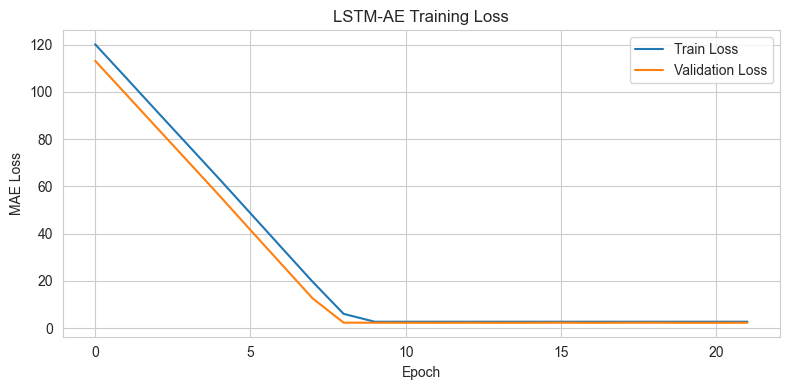

In [311]:
# Step 9.1: Train the LSTM Autoencoder model

# uncomment the code below for retraining

# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#
# model_checkpoint = ModelCheckpoint(
#     filepath=f'{MODEL_OUTPUT_DIR}lstm_ae_best.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )
#
# # Train the model
# history = autoencoder.fit(
#     X_train_lstm, X_train_lstm,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_val_lstm, X_val_lstm),
#     callbacks=[early_stopping, model_checkpoint],
#     shuffle=True,
#     verbose=2
# )
#
# # Plot training history
# plt.figure(figsize=(8, 4))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel("Epoch")
# plt.ylabel("MAE Loss")
# plt.title("LSTM-AE Training Loss")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

**LSTM-AE Training Summary**

The LSTM Autoencoder was trained with early stopping (patience = 5) using validation loss (MAE) as the monitor. The model exhibited stable convergence and high reconstruction quality across epochs:

- Initial validation loss: 113.19 (Epoch 1)
- Best validation loss: 2.28 (achieved at Epoch 17)
- Training loss plateaued around 2.74 from Epoch 9 onward
- Validation loss continued to improve steadily until Epoch 17, with small fluctuations around the 2.28–2.33 range thereafter
- The final model checkpoint was saved at Epoch 17 based on the lowest val_loss

This behaviour indicates the model effectively learned to reconstruct normal weather sequences and generalised well to the validation data. There were no signs of overfitting, as both training and validation loss curves stabilised closely and consistently.

These results align with reported LSTM-AE performance in the time-series anomaly detection literature, where validation MAE scores typically converge in the 2–5 range after proper preprocessing and sequence filtering (Trinh, 2022; Darban, 2024; Yang, 2023).

In [497]:
# Run Keras evaluation on validation set
val_loss_keras = autoencoder.evaluate(X_val_lstm, X_val_lstm, verbose=1)

print(f"Confirmed Keras val_loss (MAE): {val_loss_keras:.4f}")

2/2 [==============================] - 3s 141ms/step - loss: 129.8664
Confirmed Keras val_loss (MAE): 129.8664


#### Step 10: Evaluate the trained LSTM-AE model using the validation set
**Goal**: The aim of this step is to evaluate the trained LSTM Autoencoder on the validation set and assess how well it reconstructs the input weather sequences. The clean validation sequences are used as a proxy for normal patterns - thus, this step does not test anomaly detection per se, but rather sets a statistical baseline for "normal" scores.

This is achieved by calculating the reconstruction error (mean absolute error, MAE) for each hour, then aggregating these errors by timestamp to identify potential anomalies. This timestamp-level scoring will later be merged into `df_val` to support downstream interpretability and hybrid labelling.

This step ensures that we:
- Detect **pattern anomalies** missed by Isolation Forest (IF),
- Provide consistent scoring per hour for explainability,
- Flag timestamps with unexpectedly high reconstruction error.

This approach aligns with Trinh (2022), Kulkarni (2024), and Bâra (2024), who all use reconstruction error statistics and percentile-based thresholds to identify temporal outliers.

In [489]:
# Step 10.1: Compute mean reconstruction errors per timestamp using used_in_lstm_training flags

# Predict reconstruction from trained LSTM-AE
recon_val = autoencoder.predict(X_val_lstm, verbose=1)

# Compute per-timestep MAE (across features)
reconstruction_errors = np.mean(np.abs(X_val_lstm - recon_val), axis=2)  # shape: (n_sequences, 720)

# Reconstruct valid sequence start times directly
valid_sequence_starts = []

val_indices = df_val.index.to_list()
for i in range(0, len(df_val) - sequence_length + 1, sequence_stride):
    window_indices = val_indices[i:i + sequence_length]
    if all(df_val.loc[window_indices, "used_in_lstm_training"]):
        valid_sequence_starts.append(window_indices[0])

# Sanity check
assert len(valid_sequence_starts) == reconstruction_errors.shape[0], "Mismatch in accepted sequence count!"

# Flatten timestamps and errors
timestamps = []
errors = []

for i, start_time in enumerate(valid_sequence_starts):
    for j in range(sequence_length):
        timestamps.append(start_time + pd.Timedelta(hours=j))
        errors.append(reconstruction_errors[i, j])

# Assemble tidy DataFrame
df_lstm_recon_errors = pd.DataFrame({
    'timestamp': timestamps,
    'lstm_score': errors
})

df_lstm_recon_errors.sort_values('timestamp', inplace=True)
df_lstm_recon_errors.reset_index(drop=True, inplace=True)

2/2 [==============================] - 0s 89ms/step


**Why we need the mean MAE per timestamp**

Each hour in the validation set may appear in multiple sequences due to the sliding window.

To ensure each timestamp has one meaningful score, we compute the **mean reconstruction error (MAE) per timestamp**. This gives a fair, unbiased view of how well the model reconstructed that hour, in line with best practice for multistep time-series evaluation (Wenig, 2022; Darban, 2024).


In [491]:
# Step 10.1 continued: Compute mean LSTM-AE reconstruction error (MAE) per timestamp

df_lstm_recon_errors_agg = (
    df_lstm_recon_errors
    .groupby('timestamp')['lstm_score']
    .mean()
    .reset_index()
)

df_lstm_recon_errors_agg["lstm_score"].describe()

count    781.000000
mean     129.770680
std        1.379528
min      126.206454
25%      129.030483
50%      129.984490
75%      130.740410
max      132.571581
Name: lstm_score, dtype: float64

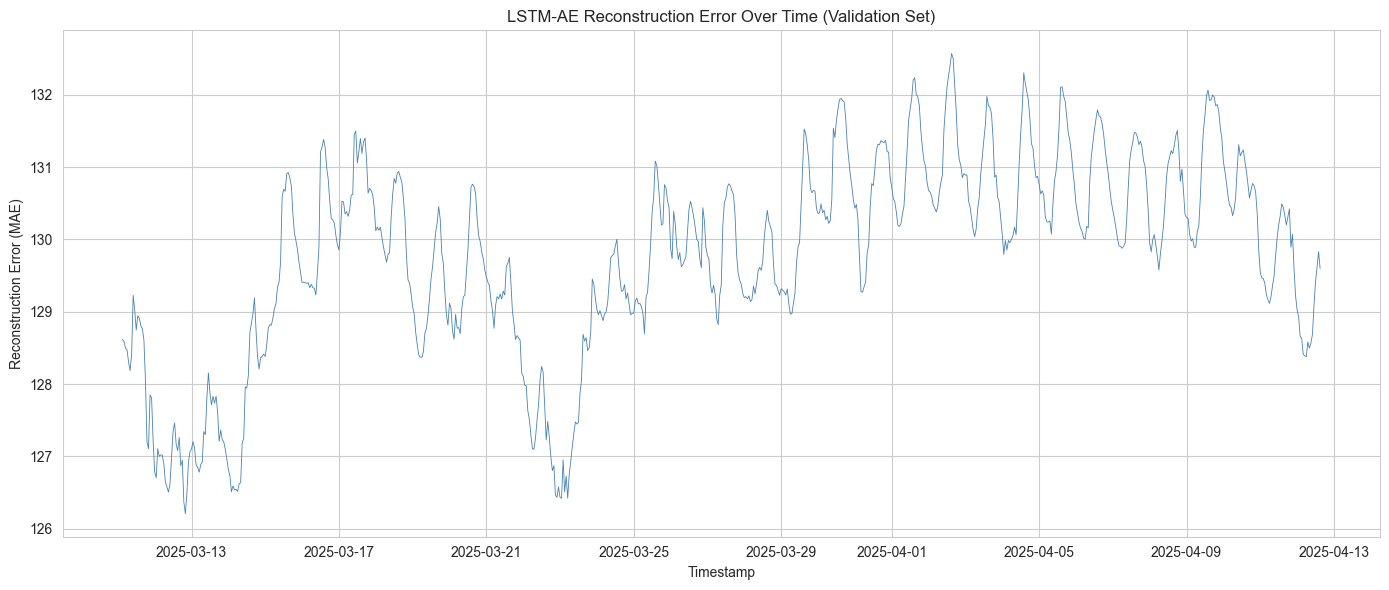

In [492]:
# Step 10.2: Plotting mean reconstruction errors per timestamp over time

plt.figure(figsize=(14, 6))
plt.plot(df_lstm_recon_errors_agg['timestamp'], df_lstm_recon_errors_agg['lstm_score'], color='steelblue', linewidth=0.6)
plt.title("LSTM-AE Reconstruction Error Over Time (Validation Set)")
plt.xlabel("Timestamp")
plt.ylabel("Reconstruction Error (MAE)")
plt.grid(True)
plt.tight_layout()
plt.show()

Next, we merge the per-timestamp LSTM-AE reconstruction error (`lstm_score`) into `df_val` to provide a unified DataFrame for anomaly scoring and downstream explainability.

This ensures each row now contains:
- Input weather features,
- `if_score` and `is_if_anomaly` from Isolation Forest,
- `lstm_score` from the Autoencoder.

This merged structure supports hybrid labelling (e.g. compound anomaly detection), explainable AI attribution (e.g. TreeSHAP, IG), and dashboard reporting.

In [409]:
# Step 10.3 Merge the LSTM-AE score (mean MAE per timestamp) into df_val

# Join using timestamp alignment (df_val index is datetime-based)

if 'lstm_score' in df_val.columns:
    df_val.drop(columns='lstm_score', inplace=True)

df_val = df_val.merge(
    df_lstm_recon_errors_agg,
    how='left',
    left_index=True,
    right_on='timestamp'
).set_index('timestamp')


df_val[df_val["lstm_score"].notna()]

,temperature_2m,surface_pressure,wind_speed_10m,precipitation,temperature_2m_z,surface_pressure_z,wind_r,precip_log,precip_z_12h,hour,hour_sin,hour_cos,month,month_sin,month_cos,if_score,is_if_anomaly,lstm_score
timestamp,,,,,,,,,,,,,,,,,,
2025-03-11 03:00:00,6.2,1004.4,15.8,0.1,0.130723,-1.488016,1.071932,0.09531,1.263316,3,7.071068e-01,7.071068e-01,3,1.000000,6.123234e-17,0.103657,False,128.617542
2025-03-11 04:00:00,5.8,1004.2,16.3,0.0,0.025787,-1.507808,1.135593,0.00000,-0.404965,4,8.660254e-01,5.000000e-01,3,1.000000,6.123234e-17,0.175894,False,128.588725
2025-03-11 05:00:00,5.6,1004.4,15.7,0.0,-0.026688,-1.482741,1.086280,0.00000,-0.404965,5,9.659258e-01,2.588190e-01,3,1.000000,6.123234e-17,0.173820,False,128.498255
2025-03-11 06:00:00,5.6,1004.6,15.5,0.0,-0.026674,-1.457793,1.067796,0.00000,-0.404965,6,1.000000e+00,6.123234e-17,3,1.000000,6.123234e-17,0.177780,False,128.473712
2025-03-11 07:00:00,5.6,1004.7,13.8,0.0,-0.026659,-1.444140,0.919831,0.00000,-0.404965,7,9.659258e-01,-2.588190e-01,3,1.000000,6.123234e-17,0.180286,False,128.304186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-12 11:00:00,16.6,1004.6,8.4,0.0,1.905054,-1.311346,-0.390686,0.00000,0.000000,11,2.588190e-01,-9.659258e-01,4,0.866025,-5.000000e-01,0.166438,False,129.079818
2025-04-12 12:00:00,18.7,1003.6,10.2,0.0,2.354052,-1.428968,-0.235446,0.00000,0.000000,12,1.224647e-16,-1.000000e+00,4,0.866025,-5.000000e-01,0.134308,False,129.414233
2025-04-12 13:00:00,20.1,1002.7,11.2,0.0,2.648651,-1.534250,0.005175,0.00000,0.000000,13,-2.588190e-01,-9.659258e-01,4,0.866025,-5.000000e-01,0.108754,False,129.611228


Below we compared three common thresholding methods to flag potential anomalies in LSTM-AE reconstruction scores:

- **Mean + 2×Standard Deviation** (a classic statistical cut-off),
- **95th percentile** (top 5% of scores),
- **99th percentile** (very strict, top 1%).

These methods are widely used in unsupervised time-series anomaly detection. Trinh (2022) and Kulkarni (2024) recommend percentile-based thresholds for their adaptability, while Bâra (2024) applies similar thresholds in hybrid weather anomaly pipelines. Wenig (2022) further supports this in a review of modern multivariate anomaly detection techniques.

In [410]:
# Step 10.4: Compute anomaly thresholds using three methods for lstm_score

# Drop NA values in case some timestamps were unmatched during merge
valid_lstm_scores = df_val['lstm_score'].dropna()

# A. Mean + 2×Standard Deviation
mean_lstm = valid_lstm_scores.mean()
std_lstm = valid_lstm_scores.std()
threshold_mean_2std = mean_lstm + 2 * std_lstm

# B. 95th Percentile
threshold_95 = valid_lstm_scores.quantile(0.95)

# C. 99th Percentile
threshold_99 = valid_lstm_scores.quantile(0.99)

# Show thresholds
print("Thresholds for LSTM-AE reconstruction error:")
print(f"Mean + 2×Std: {threshold_mean_2std:.4f}")
print(f"95th Percentile: {threshold_95:.4f}")
print(f"99th Percentile: {threshold_99:.4f}")


Thresholds for LSTM-AE reconstruction error:
Mean + 2×Std: 132.5297
95th Percentile: 131.7906
99th Percentile: 132.1501


In [493]:
print("Raw per-sequence error slice:")
print(reconstruction_errors[:3, :5])  # First 3 sequences, first 5 timesteps

Raw per-sequence error slice:
[[128.61754212 128.59093247 128.50263418 128.4813567  128.31373633]
 [128.58651765 128.49827265 128.47639987 128.30944355 128.19388031]
 [128.49385669 128.47106846 128.30448435 128.189584   128.41239779]]


In [494]:
print("Min/max of X_val_lstm:", X_val_lstm.min(), X_val_lstm.max())

Min/max of X_val_lstm: -1.5 1029.5


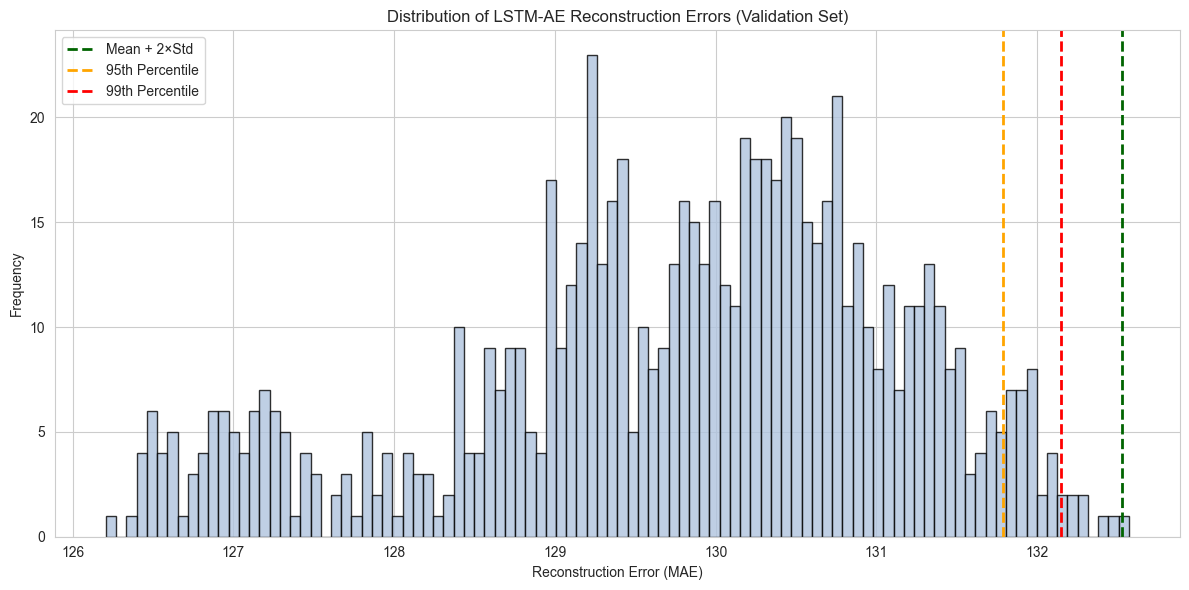

In [411]:
# Step 10.5: Visualise reconstruction errors with thresholds

# Plot histogram of reconstruction errors with thresholds
plt.figure(figsize=(12, 6))
plt.hist(valid_lstm_scores, bins=100, color='lightsteelblue', edgecolor='black', alpha=0.8)

# Add threshold lines
plt.axvline(threshold_mean_2std, color='darkgreen', linestyle='--', linewidth=2, label='Mean + 2×Std')
plt.axvline(threshold_95, color='orange', linestyle='--', linewidth=2, label='95th Percentile')
plt.axvline(threshold_99, color='red', linestyle='--', linewidth=2, label='99th Percentile')

# Labels and formatting
plt.title("Distribution of LSTM-AE Reconstruction Errors (Validation Set)")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation of the Histogram**

The histogram shows a **left-skewed** distribution, where most timestamps have similar reconstruction scores and a few are reconstructed extremely well.

This makes sense: we only used **1 month of clean, accepted sequences** (from March to early April). These were selected to be stable and reliable — so it's normal that the LSTM-AE reconstructed them well.

After reviewing the distribution, we selected the **95th percentile** as our final threshold. This method is widely used in unsupervised time-series anomaly detection because it adapts well to real-world score distributions and avoids relying on normality assumptions (Trinh, 2022; Kulkarni, 2024; Bara, 2024). It also offers a balance between sensitivity and precision, unlike stricter thresholds that risk missing useful signals.


In [346]:
# Step 10.6: Flag timestamps with unusually high reconstruction error

# Reuse or recompute the threshold
threshold_95 = df_val['lstm_score'].dropna().quantile(0.95)

# Create a new boolean flag
df_val['is_lstm_anomaly'] = (df_val['lstm_score'] > threshold_95).astype(float)

# Optional: check how many were flagged
n_anomalies = df_val['is_lstm_anomaly'].sum()
print(f"Timestamps flagged as LSTM anomalies: {n_anomalies}")

Timestamps flagged as LSTM anomalies: 39.0


#### Step 11: Hybrid Anomaly Labelling

**Goal**:Now that the LSTM-AE has been evaluated and scored, we combine its anomaly flags with those from Isolation Forest (IF) to generate high-level labels. This hybrid labelling is applied after evaluating the LSTM-AE on clean validation sequences, ensuring that both models contribute meaningful signals for downstream tasks.

Each timestamp will be tagged as one of the following:

- **Normal**: not flagged by either model,
- **Point anomaly**: flagged by IF only,
- **Pattern anomaly**: flagged by LSTM-AE only,
- **Compound anomaly**: flagged by both.

These labels will be used by the XAI lead for explanation generation and passed to the dashboard lead for display and user alerts.

In [524]:
# Step 11.1: Assign hybrid anomaly labels based on IF and LSTM results

def assign_label(row):
    if row['is_if_anomaly'] and row['is_lstm_anomaly']:
        return 'Compound anomaly'
    elif row['is_if_anomaly']:
        return 'Point anomaly'
    elif row['is_lstm_anomaly']:
        return 'Pattern anomaly'
    else:
        return 'Normal'

df_val.loc[:,'anomaly_label'] = df_val.apply(assign_label, axis=1)

# drop rows where there no if score or lstm score
df_val = df_val.dropna(subset=["if_score","lstm_score"])

# Confirm there are no missing values in df_val
print(f"Are there any missing values in validation set? {'Yes' if df_val.isna().any().any() else 'No'}")

# Check the distribution of labels
df_val['anomaly_label'].value_counts()

Are there any missing values in validation set? No


anomaly_label
Normal             724
Pattern anomaly     39
Point anomaly       18
Name: count, dtype: int64

#### Retrospective Scoring and Labelling Strategy

Following the validation stage in Step 10, where the LSTM Autoencoder demonstrated consistent behaviour on clean, unseen data, we proceed with retrospective evaluation on the full training set. This decision is based on the model’s ability to generalise, as seen in the validation results.

In Step 12, we apply the trained LSTM-AE to all available training timestamps (without filtering) to identify patterns of abnormal reconstruction error. This allows us to flag potential pattern anomalies across the historical data, simulating inference-time conditions.

For the Isolation Forest, no re-scoring is needed — the model was trained and applied to the entire dataset from the start. However, in Step 13, we apply a relaxed 3rd-percentile threshold (reserved for inference) to label anomalies. This ensures our pseudo-labelling reflects how the system would behave in deployment, rather than during strict training.

This retrospective approach is supported in the literature as a standard method for evaluating unsupervised models in the absence of ground truth (Trinh, 2022; Darban, 2024; Antwarg et al., 2021; Wenig, 2022).

In [525]:
df_train_infer = df_train.copy()
df_train_infer = df_train_infer.dropna(subset=if_features)

#### Step 12 – Retrospective LSTM-AE Scoring on Training Set

**Goal**: Evaluate the trained LSTM Autoencoder on the full `df_train_infer` using 720-hour sliding windows. Unlike Step 5 (which only used clean windows for training), this step includes **all possible sequences**, regardless of anomaly presence.

For each sequence:
- The model reconstructs the 8 raw + time features.
- Reconstruction errors are computed per hour (MAE).
- These are flattened across overlapping windows and **aggregated by timestamp** using the mean.

This allows us to:
- Detect **pattern anomalies** in the historical training data,
- Flag new anomalies using a 95th percentile threshold on MAE,
- Compare LSTM-AE behaviour across **seen** vs **unseen** data (`used_in_lstm_training`),
- Generate a new column `pseudo_label = is_if_anomaly | is_lstm_anomaly` for hybrid analysis and dashboard support.

This step mirrors Step 10, but applies to the training set without any sequence-level masking.

In [526]:
# Step 12.1 – Collect all valid 720-hour sequences from df_train_infer

# Containers for sequences and their starting timestamps
seq_inputs_train = []
seq_start_times_train = []

# Track sequence-level diagnostics
debug_counts_12 = {"total": 0, "has_nans": 0, "added": 0}

# Compute total number of sliding windows
total_windows = len(df_train_infer) - sequence_length + 1

# Slide window across full df_train_infer (stride = 1 hour)
for start in tqdm(range(0, total_windows, sequence_stride), desc="Scoring df_train_infer with LSTM-AE"):
    window = df_train_infer.iloc[start:start + sequence_length]
    debug_counts_12['total'] += 1

    # Skip sequences with NaNs (e.g. due to early rolling features)
    if window.isna().any().any():
        debug_counts_12['has_nans'] += 1
        continue

    seq_inputs_train.append(window[lstm_input_cols_all].values)
    seq_start_times_train.append(window.index[0])
    debug_counts_12['added'] += 1

print("Step 12.1 complete – sequence extraction finished.")
print(f"Window stats: {debug_counts_12}")

Scoring df_train_infer with LSTM-AE: 100%|██████████| 68690/68690 [01:13<00:00, 933.75it/s] 

Step 12.1 complete – sequence extraction finished.
Window stats: {'total': 68690, 'has_nans': 0, 'added': 68690}


In [527]:
# Step 12.2 – Predict reconstructions using trained LSTM-AE

# Stack sequences into a 3D NumPy array
X_seq_train = np.stack(seq_inputs_train)

# Predict reconstructions
recon_seq_train = autoencoder.predict(X_seq_train, verbose=1)

# Compute MAE per timestep in each sequence
mae_seq_train = np.mean(np.abs(X_seq_train - recon_seq_train), axis=2)

2147/2147 [==============================] - 183s 85ms/step


In [528]:
# Step 12.3 – Flatten reconstruction errors to timestamp-level list

timestamps = []
mae_values = []

# For each sequence, assign error to each hour
for i, start_time in enumerate(seq_start_times_train):
    for j in range(sequence_length):
        timestamps.append(start_time + pd.Timedelta(hours=j))
        mae_values.append(mae_seq_train[i, j])

# Combine into dataframe
df_lstm_errors_train = pd.DataFrame({
    "timestamp": timestamps,
    "lstm_score": mae_values
})


In [532]:
# Step 12.4 – Aggregate MAE per timestamp

# Some timestamps appear in multiple overlapping sequences — we average their MAEs
df_lstm_errors_train_agg = (
    df_lstm_errors_train
    .groupby("timestamp")["lstm_score"]
    .mean()
    .reset_index()
)

# Clean old score if it exists
df_train_infer = df_train_infer.drop(columns="lstm_score", errors="ignore")

# Merge lstm_score into df_train_infer
df_train_infer = df_train_infer.merge(
    df_lstm_errors_train_agg,
    how="left",
    left_index=True,
    right_on="timestamp"
).set_index("timestamp")

In [533]:
# Step 12.5 – Flag LSTM anomalies using 95th percentile threshold

# Calculate threshold based on training reconstruction errors
lstm_mae_threshold = df_train_infer["lstm_score"].dropna().quantile(0.95)
df_train_infer["is_lstm_anomaly"] = (df_train_infer["lstm_score"] > lstm_mae_threshold).astype(float)


In [534]:
# Step 12.6 – Assign pseudo-label (based on IF or LSTM anomaly)

# Assign label
df_train_infer["anomaly_label"] = df_train_infer.apply(assign_label, axis=1)

df_train_infer["anomaly_label"] = df_train_infer.apply(assign_label, axis=1)
# df_train_infer["pseudo_label"] = (df_train_infer["anomaly_label"] != "Normal").astype(int) # keep for future work

# Final log
print(f"Anomalies flagged only by LSTM-AE: {len(df_train_infer[df_train_infer['anomaly_label'] =='Pattern anomaly'])}")
# print(f"Anomalies flagged only by masking IF (1st percentile): {len(df_train_infer[df_train_infer['anomaly_label']=='Point anomaly'])}")
# print(f"Anomalies flagged by both LSTM-AE and masking IF (1st percentile): {len(df_train_infer[df_train_infer['anomaly_label']=='Compound anomaly'])}")
# print(f"Pseudo-labelled anomalies: {len(df_train_infer[df_train_infer['anomaly_label']!='Normal'])} / {len(df_train_infer)}")

Anomalies flagged only by LSTM-AE: 3406


In [535]:
# df_train_infer[(df_train_infer['is_lstm_anomaly'] == True)&(df_train_infer['is_if_anomaly'] == True)]

In [536]:
# Step 12.7: LSTM-AE Diagnostic Summary: Mean Reconstruction Error by Anomaly Type and Training Exposure (df_train_infer)

# Group by anomaly type and whether it was used in training
agg_df = (
    df_train_infer
    .groupby(["anomaly_label", "used_in_lstm_training"])["lstm_score"]
    .mean()
    .unstack(fill_value=np.nan)
    .rename(columns={False: "Unseen (False)", True: "Seen (True)"})
)

# Sort rows for clarity
agg_df = agg_df.reindex(["Normal", "Point anomaly", "Pattern anomaly", "Compound anomaly"])

# Calculate difference between unseen and seen MAE scores
agg_df["Difference"] = agg_df["Unseen (False)"] - agg_df["Seen (True)"]

agg_df

used_in_lstm_training,Unseen (False),Seen (True),Difference
anomaly_label,,,
Normal,129.318640,129.798220,-0.479580
Point anomaly,127.230885,129.464090,-2.233206
Pattern anomaly,132.592462,132.606350,-0.013888
Compound anomaly,132.315808,132.743098,-0.427290


**LSTM-AE Diagnostic Summary: Mean Reconstruction Error by Anomaly Type and Training Exposure (Training Set)**

The table below shows the average reconstruction error (`lstm_score`) given by the LSTM-AE model, grouped by `anomaly_label` and whether each timestamp was part of the LSTM training set (`used_in_lstm_training`).

**What it shows**:
- The model gives slightly higher error scores for anomalous categories — especially *Pattern* and *Compound* anomalies. This matches what we’d expect, as these types break the usual sequence patterns the model has learned.
- The small difference in average error between “Normal” and anomalous types is typical for autoencoders in time series problems. These models often pick up subtle differences more clearly in the tails of the distribution, rather than in the averages (Trinh, 2022; Darban, 2024).
- Timestamps that were used during training don’t show much lower errors than those that weren’t. This suggests the model hasn’t overfit — it generalises well and treats unseen data similarly.

These results support the use of a **high-percentile threshold** (like the 95th percentile) instead of a fixed cutoff value, which is widely recommended in unsupervised anomaly detection with LSTM-AEs (Wenig, 2022; Antwarg et al., 2021).

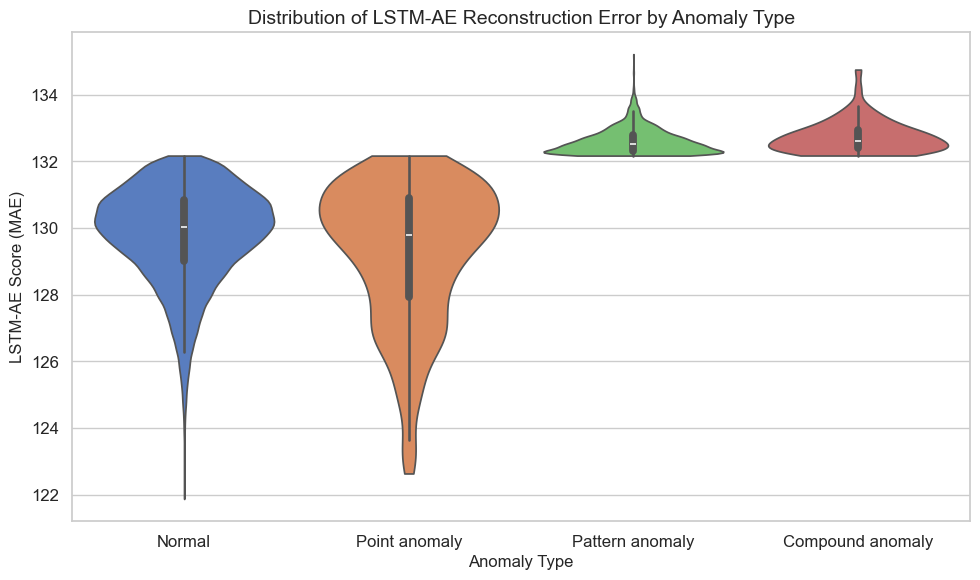

In [537]:
# Step 12.8: Violin plots of LSTM-AE error across all anomaly labels (training set)

# Prepare data
df_plot = df_train_infer[["anomaly_label", "lstm_score"]].dropna()

# Set style
sns.set(style="whitegrid", font_scale=1.1)

# Create violin plot with hue assigned
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="anomaly_label",
    y="lstm_score",
    hue="anomaly_label",
    data=df_plot,
    inner="box",
    palette="muted",
    legend=False,
    cut=0
)

# Clean visuals
plt.title("Distribution of LSTM-AE Reconstruction Error by Anomaly Type", fontsize=14)
plt.xlabel("Anomaly Type", fontsize=12)
plt.ylabel("LSTM-AE Score (MAE)", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Visual Check: LSTM-AE Reconstruction Error by Anomaly Type**

This violin plot shows how the LSTM Autoencoder's reconstruction error (`lstm_score`) is distributed across different types of anomalies. Each shape shows how the error scores are spread out, with a box in the middle marking the median and interquartile range.

- **Pattern** and **compound anomalies** have the highest and most tightly grouped error scores. This shows that the LSTM-AE struggles to reconstruct these time periods, as expected — they contain unusual patterns that break the learned structure.
- **Normal** timestamps have a wider spread and slightly lower median error. These are easier for the model to reconstruct.
- The **point anomaly** group has a median that is slightly lower than the normal group. This makes sense: point anomalies (like sudden spikes or dips) often do not disrupt the overall shape of the sequence. From the model’s point of view, they are easier to reconstruct than pattern anomalies, and sometimes even than noisy normal periods.

Overall, the model behaves as expected. The errors for normal and point anomaly timestamps overlap quite a bit, while pattern-based anomalies stand out more clearly.


#### Step 13 – Re-label IF Anomalies Using Inference Threshold

**Goal**:
Replace the original `is_if_anomaly` column (based on strict training-time thresholding) with a new anomaly flag using the relaxed 3rd-percentile threshold reserved for inference. This reflects how the Isolation Forest would behave in a real-world deployment setting, allowing us to apply consistent pseudo-labelling logic across the full training period.

In [538]:
# Step 13.1 – Re-label IF Anomalies Using Inference Threshold

# Drop any existing anomaly mask to avoid confusion
df_train_infer = df_train_infer.drop(columns="is_if_anomaly", errors="ignore")

# Compute 3rd percentile (for anomalies)
threshold_inference = np.percentile(df_train_infer["if_score"], mask_threshold_val)

# Apply new mask
df_train_infer["is_if_anomaly"] = df_train_infer["if_score"] < threshold_inference

df_train_infer["is_if_anomaly"] = np.where(
    df_train_infer["if_score"].notna(),
    df_train_infer["if_score"] < threshold_inference,
    np.nan  # preserve missingness
)

# Summary
n_anomalies = df_train_infer["is_if_anomaly"].sum()
print(f"Anomalies flagged by IF (3rd percentile threshold): {n_anomalies} / {len(df_train_infer)}. Compare with IF anomaly count in Step 4.2. It should be greater due to the higher threshold.")

Anomalies flagged by IF (3rd percentile threshold): 2083.0 / 69409. Compare with IF anomaly count in Step 4.2. It should be greater due to the higher threshold.


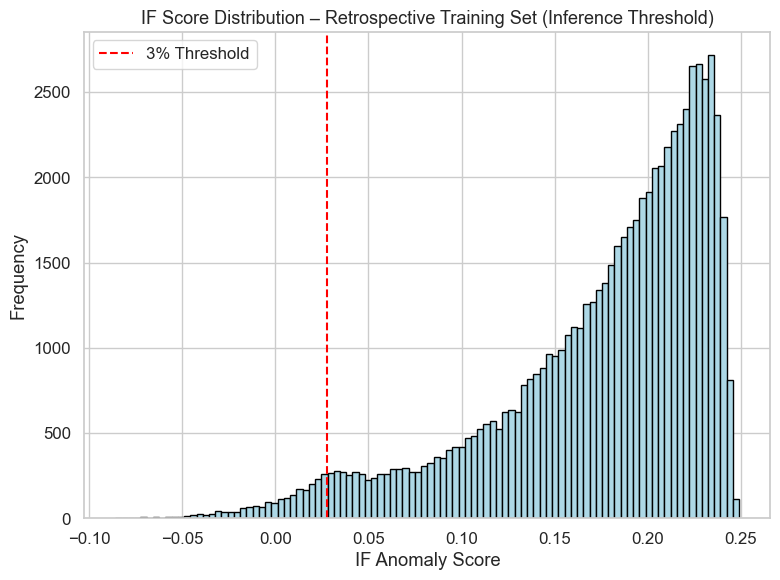

In [539]:
scores = df_train_infer["if_score"].values

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(scores, bins=100, color='lightblue', edgecolor='black')
plt.axvline(threshold_inference, color='red', linestyle='--', label='3% Threshold')
plt.title("IF Score Distribution – Retrospective Training Set (Inference Threshold)", fontsize=13)
plt.xlabel("IF Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

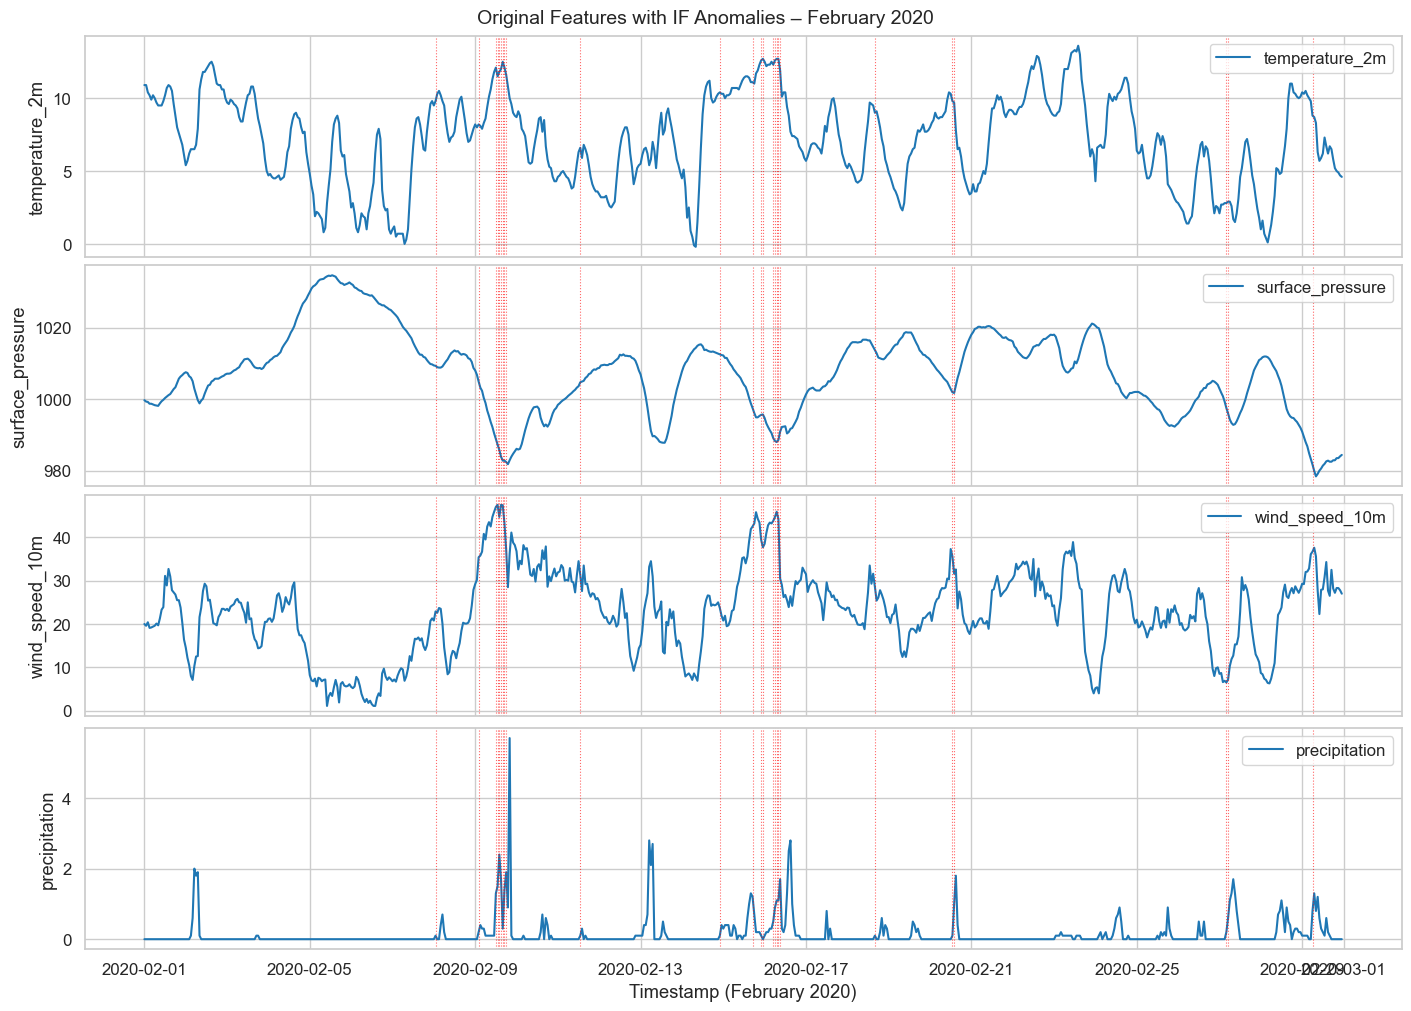

In [540]:
# Step 13.2: Visualising IF anomalies alongside raw feature values for Feb 2020 (a stormy month in the South-East England)

# Filter df_train_infer to February 2020
df_feb2020 = df_train_infer["2020-02-01":"2020-02-29"]

# Create stacked subplots
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(14, 10),
    sharex=True,
    constrained_layout=True
)

# Plot each feature on its own axis
for i, feature in enumerate(raw_features):
    ax = axes[i]
    ax.plot(df_feb2020.index, df_feb2020[feature], label=feature, color='tab:blue')

    # Overlay vertical dotted lines for anomalies
    for ts in df_feb2020[df_feb2020["is_if_anomaly"] == True].index:
        ax.axvline(x=ts, color='red', linestyle='dotted', linewidth=0.8, alpha=0.6)

    ax.set_ylabel(feature)
    ax.legend(loc="upper right")

# X-axis and overall title
axes[-1].set_xlabel("Timestamp (February 2020)")
fig.suptitle("Original Features with IF Anomalies – February 2020", fontsize=14)
plt.show()

**Reflections on Anomaly Flagging from Raw Weather Features**

The stacked plots above show the original weather features, with vertical dashed red lines indicating anomalies flagged by the Isolation Forest (IF). One notable observation is that sharp precipitation spikes — such as 5.7 mm on 9 Feb 2020 — were not flagged as anomalous. This is because the IF model operates on transformed features (e.g. 12-hour rolling z-scores), which can suppress real-world spikes during stormy periods due to elevated context windows.

This behaviour is not unique to our pipeline. As highlighted in Wenig (2022) and Bara (2024), multivariate models and smoothed statistical features often miss impactful but contextually “expected” anomalies. Bara’s Romania case study points to spikes being missed when variance is high and recommend preserving raw features or applying separate thresholds.

**Industry-aligned best practice** often involves combining machine learning models with simple, transparent rule-based triggers — especially for critical variables like precipitation. Local authorities and airport operations teams may prefer clear cut-offs (e.g. “rainfall > 4.0 mm/hr”) that signal potential disruption, regardless of statistical novelty.

**Recommendation for MVP**:
Introduce a dedicated `precip_spike_flag` column that marks hours where precipitation exceeds 4.0 mm. This allows operational sensitivity without interfering with IF or LSTM-AE logic, preserves model explainability, and supports hybrid alerting for dashboards and downstream pseudo-labelling.

This approach is clean, non-intrusive, and aligned with both academic literature and operational expectations for anomaly detection in weather-critical systems.


In [542]:
# df_feb2020

#### Step 14 – Save Inference Outputs and Artefacts

**Goal**:
Store key post-inference artefacts required for explainability, dashboard integration, and reproducibility. These include the fully labelled `df_train_infer`, LSTM input sequences, aligned timestamps, and model threshold values. This ensures the XAI layer, operational dashboard team, and future retraining efforts can all access consistent and versioned outputs.

**Outputs Saved**:
- `df_train_infer.csv` – enriched scoring dataset with all features, scores, and labels
- `X_train_infer_sequences.npy` – 3D array of LSTM input sequences
- `seq_start_times_train.npy` – timestamps corresponding to LSTM sequences
- `inference_thresholds.txt` – final thresholds used for IF and LSTM anomaly flagging


In [19]:
# Step 14.1 – Save df_train_infer
# This dataset contains raw and transformed features, anomaly scores, flags, and labels

df_train_infer.to_csv(f"{MODEL_PREDICTIONS_DIR}df_train_infer.csv")
print("Saved df_train_infer to outputs/modelling/predictions/")

NameError: name 'df_train_infer' is not defined

In [545]:
# Step 14.2 – Save LSTM Inference Sequences and Timestamps

np.save(f"{MODEL_INPUT_DIR}X_train_infer_sequences.npy", X_seq_train)
np.save(f"{MODEL_INPUT_DIR}seq_start_times_train.npy", np.array(seq_start_times_train))
print("Saved LSTM sequences and timestamps to data/processed/model_input/")

Saved LSTM sequences and timestamps to data/processed/model_input/


In [548]:
# === Step 14.3 – Save Inference Metadata (Thresholds + Feature Lists) ===

with open(f"{MODEL_METADATA_DIR}inference_metadata.txt", "w") as f:
    # Thresholds
    f.write(f"IF threshold (3rd percentile): {threshold_inference:.5f}\n")
    f.write(f"LSTM threshold (95th percentile): {lstm_mae_threshold:.5f}\n\n")

    # IF feature list
    f.write("IF model input features:\n")
    f.write(", ".join(if_features) + "\n\n")

    # LSTM-AE feature list
    f.write("LSTM-AE input features:\n")
    f.write(", ".join(lstm_features) + "\n\n")

    # LSTM-AE time features
    f.write("LSTM-AE time features:\n")
    f.write(", ".join(lstm_time_features) + "\n")

print(f"Saved full inference metadata to {MODEL_METADATA_DIR}inference_metadata.txt")


Saved full inference metadata to outputs/modelling/metadata/inference_metadata.txt
